In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import importlib
import matplotlib.pyplot as plt
import numpy as np
import knowyourdata as kyd

import pandas as pd
from traffic_prophet import cfg
import pathlib, os
import configparser

from traffic_prophet import connection
from traffic_prophet.countmatch import reader
from traffic_prophet.countmatch import growthfactor as gf
from traffic_prophet.countmatch import neighbour

defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

filepath = pathlib.Path.home().joinpath('.charlesconfig')
if os.path.isfile(filepath):
    vol_conn = connection.Connection(filepath, 'POSTGRES',
                                     'czhu.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'POSTGRES',
                                    'czhu.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['MAPBOX']['token']
    PLOTLY_USER = config['PLOTLY']['user']
    PLOTLY_KEY = config['PLOTLY']['key']
else:
    filepath = pathlib.Path.home().joinpath('cf.txt')
    vol_conn = connection.Connection(filepath, 'localpg',
                                     'prj_vol.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'localpg',
                                    'gis.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['mapbox']['token']
    PLOTLY_USER = config['plotly']['user']
    PLOTLY_KEY = config['plotly']['apikey']

In [2]:
rdr = reader.Reader(vol_conn)
rdr.read()
gf.get_growth_factors(rdr)

In [3]:
ptc_ids = np.unique(np.abs(list(rdr.ptcs.keys())))
nb = neighbour.NeighbourLonLatEuclidean(ll_conn, 20, ptc_ids)
nb.find_neighbours()

In [10]:
import importlib
import countmatch_teps as cmt
import countmatch_bagheri as cmb
import countmatch_hybrid as cmh
import countmatch_validator as cmv
importlib.reload(cmv)
importlib.reload(cmb)
importlib.reload(cmh)
importlib.reload(cmt)

<module 'countmatch_teps' from '/mnt/c/Users/czhu5/Documents/Ubuntu/GitHub/bdit_traffic_prophet/development_notebooks/countmatch_teps.py'>

In [27]:
from tqdm.auto import tqdm

In [11]:
fake_dataset = cmv.generate_test_database(rdr, n_sets=100, progress_bar=True)

In [16]:
len(fake_dataset[0].sttcs)

166

In [17]:
sttc_n_years = [len(x.data.index.levels[0]) for x in rdr.sttcs.values()]

In [18]:
fake_sttc_n_years = []
for dset in fake_dataset:
    fake_sttc_n_years += [len(x.data.index.levels[0]) for x in dset.sttcs.values()]

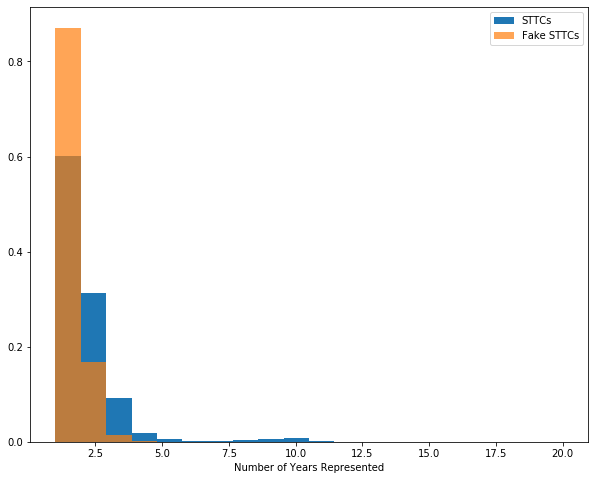

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(sttc_n_years, bins=20, range=(1, 20), density=True, label='STTCs');
ax.hist(fake_sttc_n_years, bins=20, range=(1, 20), density=True, alpha=0.7, label='Fake STTCs')
ax.legend(loc=1)
ax.set_xlabel("Number of Years Represented");

In [22]:
sttc_dyears = [max(x.data.index.levels[0]) - min(x.data.index.levels[0]) for x in rdr.sttcs.values()]

fake_sttc_dyears = []
for dset in fake_dataset:
    fake_sttc_dyears += [max(x.data.index.levels[0]) - min(x.data.index.levels[0]) for x in dset.sttcs.values()]

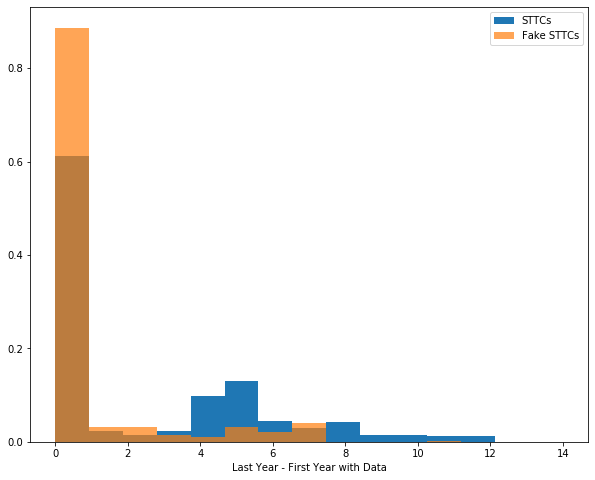

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(sttc_dyears, bins=15, range=(0, 14), density=True, label='STTCs');
ax.hist(fake_sttc_dyears, bins=15, range=(0, 14), density=True, alpha=0.7, label='Fake STTCs')
ax.legend(loc=1)
ax.set_xlabel("Last Year - First Year with Data");

In [24]:
sttc_startyears = [min(x.data.index.levels[0]) for x in rdr.sttcs.values()]

fake_sttc_startyears = []
for dset in fake_dataset:
    fake_sttc_startyears += [min(x.data.index.levels[0]) for x in dset.sttcs.values()]

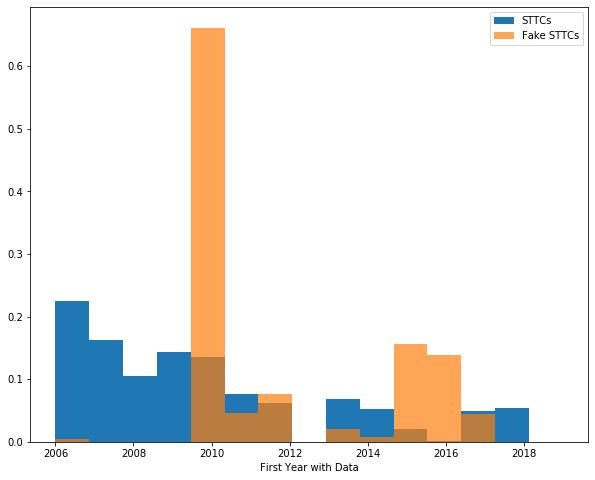

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(sttc_startyears, bins=15, range=(2006, 2019), density=True, label='STTCs');
ax.hist(fake_sttc_startyears, bins=15, range=(2006, 2019), density=True, alpha=0.7, label='Fake STTCs')
ax.legend(loc=1)
ax.set_xlabel("First Year with Data");

# SHOOTOUT - estimate-to-estimate variation for 2018

In [26]:
want_year = 2018

In [30]:
teps_estimates = []
for dset in tqdm(fake_dataset, desc='Running countmatch_teps'):
    teps_estimates.append(
        cmt.estimate_aadts(dset, nb, want_year, n_neighbours=5,
                           single_direction=True, progress_bar=False))

In [64]:
def get_estimate_averages(estimates):
    aadts = pd.concat(
        [(x.sort_values('Count ID')[['Count ID', 'AADT Estimate']]
          .set_index('Count ID', drop=True))
         for x in estimates], axis=1)
    aadts.columns = list(range(len(estimates)))
    aadts['average'] = aadts.mean(axis=1)
    aadts['std'] = aadts.std(axis=1)
    aadts['cov'] = aadts['std'] / aadts['average']
    return aadts

teps_aadts = get_estimate_averages(teps_estimates)

In [81]:
hybrid_estimates = []
for dset in tqdm(fake_dataset, desc='Running countmatch_hybrid'):
    hybrid_estimates.append(
        cmh.estimate_aadts(dset, nb, want_year, n_neighbours=5,
                           single_direction=True, progress_bar=False))

In [82]:
hybrid_estimates_ggf = []
for dset in tqdm(fake_dataset, desc='Running countmatch_hybrid_ggf'):
    hybrid_estimates_ggf.append(
        cmh.estimate_aadts(dset, nb, want_year, n_neighbours=5,
                           override_growth_factor=True,
                           single_direction=True, progress_bar=False))

In [83]:
bagheri_estimates_mseggf = []
for dset in tqdm(fake_dataset, desc='Running countmatch_bagheri_mseggf'):
    bagheri_estimates_mseggf.append(
        cmb.estimate_aadts(dset, nb, want_year, n_neighbours=5,
                           override_growth_factor=True, erroralgo='Minimum MSE',
                           single_direction=True, progress_bar=False))

In [84]:
hybrid_aadts = get_estimate_averages(hybrid_estimates)

In [85]:
hybrid_ggf_aadts = get_estimate_averages(hybrid_estimates_ggf)

In [86]:
bagheri_mseggf_aadts = get_estimate_averages(bagheri_estimates_mseggf)

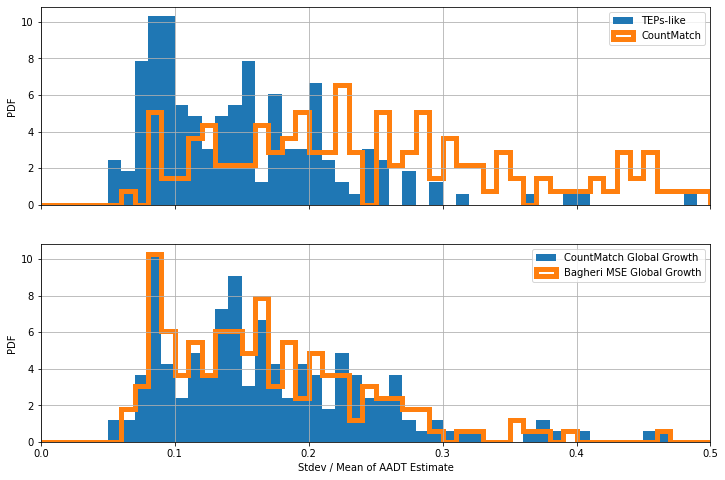

In [102]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
teps_aadts['cov'].hist(ax=ax[0], bins=50, range=(0., 0.5), density=True, label='TEPs-like',
                       lw=2)
hybrid_aadts['cov'].hist(ax=ax[0], bins=50, range=(0., 0.5), density=True, label='CountMatch',
                         histtype='step', lw=5)
hybrid_ggf_aadts['cov'].hist(ax=ax[1], bins=50, range=(0., 0.5), density=True, label='CountMatch Global Growth',
                             lw=2)
bagheri_mseggf_aadts['cov'].hist(ax=ax[1], bins=50, range=(0., 0.5), density=True, label='Bagheri MSE Global Growth',
                                 histtype='step', lw=5)
ax[0].legend(loc=1)
ax[1].legend(loc=1)
ax[1].set_xlabel('Stdev / Mean of AADT Estimate')
ax[0].set_ylabel('PDF')
ax[1].set_ylabel('PDF')
ax[1].set_xlim([0, 0.5]);

In [103]:
teps_aadts['cov'].median()

0.13967710032647102

In [104]:
bagheri_mseggf_aadts['cov'].median()

0.15742421955781677

In [ ]:
datasets, aadt_validation = cmv.validation(rdr, nb, cmb.estimate_aadts, algo_args=
                                           {'override_growth_factor': True}, n_sets=2, progress_bar=True)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
for i in range(3):
    ax.plot(jjabrams['ground_truth'].values, jjabrams[i].values, ls='None', marker='o')
ax.set_ylim([0, 100000])